In [128]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from datetime import datetime
from math import *

date_format = "%m/%d/%Y"

In [129]:
class Bond():
    def __init__(self, data):
        self.coupon = float(data[0])
        self.matur = datetime.strptime(data[1], date_format)
        self.prices = []
        for i in range(2, len(data)):
            self.prices.append(float(data[i]))

In [130]:
# Import and set up data
dates = ['1/10/2022', '1/11/2022', '1/12/2022', '1/13/2022', '1/14/2022', 
         '1/17/2022', '1/18/2022', '1/19/2022', '1/20/2022', '1/21/2022']
formatted_dates =  []
for d in dates:
    a = datetime.strptime(d, date_format)
    formatted_dates.append(a)
    
bonds = []
with open('selected_bonds.csv', newline='') as filename:
    csvreader = csv.reader(filename)
    for row in csvreader:
        b = Bond(row)
        bonds.append(b)

In [131]:
# Calculate yield curve
def yield_equation(price, coupon, matur, cur_date, rate):
    ans = price
    t = (matur - cur_date).days # days till maturity
    t /= 365.0 # convert to years
    ans -= 100 * exp(-rate * t)
    while t > 0:
        ans -= coupon * exp(-rate * t)
        t -= 0.5
    return ans

def find_yield_rate(price, coupon, matur, cur_date):
    """
    find_yield_rate uses binary search to find the ytm
    """
    lo = 0
    hi = 0.1
    while lo < hi:
        mid = (lo + hi) / 2
        ans = yield_equation(price, coupon, matur, cur_date, mid)
        if abs(ans) < 0.0001:
            return mid * 100
        elif ans > 0:
            hi = mid
        else:
            lo = mid
            
yields = []
times = []
# for each day, calculate the ytm for each bond
for i in range(len(formatted_dates)):
    day_curve = []
    matur_times = []
    for b in bonds:
        r = find_yield_rate(b.prices[i], b.coupon, b.matur, formatted_dates[i])
        t = (b.matur - formatted_dates[i]).days
        t /= 365.0
        matur_times.append(t)
        day_curve.append(r)
        
    yields.append(day_curve)
    times.append(matur_times)

print(yields[0])

[3.3496093750000004, 1.1770629882812502, 1.28814697265625, 1.6851806640625002, 1.4932250976562498, 2.195053100585938, 2.904052734375, 2.0489883422851567, 1.7690277099609377, 2.685394287109375, 3.0038452148437496]


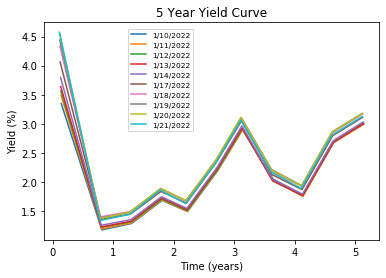

In [132]:
# Plot yield curve
for i in range(len(yields)):
    plt.plot(times[i], yields[i], label=dates[i])
plt.title("5 Year Yield Curve")
plt.xlabel("Time (years)")
plt.ylabel("Yield (%)")
plt.legend(loc = (0.25, 0.5), prop={'size': 7.5})
plt.savefig('yield.png')

# Yield curve has up and down movement since not all bonds have exact same coupon.

In [133]:
# calculate spot curve
spot_rates = []
def spot_equation(price, coupon, matur, cur_date, rate):
    ans = price
    t = (matur - cur_date).days # days till maturity
    t /= 365.0 # convert to years
    ans -= (100 + coupon) * exp(-rate * t)
    t -= 0.5
    i = 0
    while t > 0: # discount coupon at the corresponding spot rate
        ans -= coupon * exp(-spot_rates[i] * t)
        i += 1
        t -= 0.5
    return ans

def find_spot_rate(price, coupon, matur, cur_date):
    """
    Use binary search to find the spot rate from the spot equation
    """
    lo = 0
    hi = 0.1
    while lo < hi:
        mid = (lo + hi) / 2
        ans = spot_equation(price, coupon, matur, cur_date, mid)
        if abs(ans) < 0.0001:
            spot_rates.insert(0, mid)
            return mid * 100
        elif ans > 0:
            hi = mid
        else:
            lo = mid
            
spots = []
times = []
# for each day, calculate the ytm for each bond
for i in range(len(formatted_dates)):
    day_curve = []
    matur_times = []
    spot_rates = []
    for b in bonds:
        r = find_spot_rate(b.prices[i], b.coupon, b.matur, formatted_dates[i])
        t = (b.matur - formatted_dates[i]).days
        t /= 365.0
        matur_times.append(t)
        day_curve.append(r)
        
    spots.append(day_curve)
    times.append(matur_times)
    
print(spots[0])
# spot rates are slightly different than the ytm rates

[3.3496093750000004, 1.1749267578125, 1.287078857421875, 1.6864013671875004, 1.4929199218749998, 2.2063446044921875, 2.9443359375, 2.0489120483398438, 1.7663955688476562, 2.7156066894531246, 3.058013916015625]


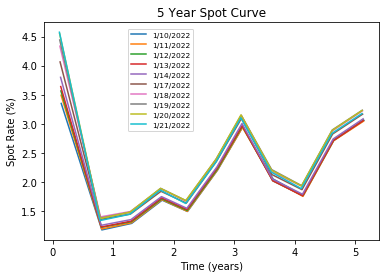

In [134]:
# Plot spot curve
for i in range(len(spots)):
    plt.plot(times[i], spots[i], label=dates[i])
plt.title("5 Year Spot Curve")
plt.xlabel("Time (years)")
plt.ylabel("Spot Rate (%)")
plt.legend(loc = (0.25, 0.5), prop={'size': 7.5})
plt.savefig('spot.png')

In [135]:
# calculate forward curve

year_spot_rates = []
for i in range(len(dates)):
    # interpolate spot rates to exactly 1 year marks
    spots_today = []
    s = spots[i]
    t = times[i]
    for j in range(1, 6):
        t1 = t[2*j-1]
        t2 = t[2*j]
        s1 = s[2*j-1]
        s2 = s[2*j]
        ratio = (j-t1) / (t2-t1)
        spot = ratio * s1 + (1 - ratio) * s2
        spots_today.append(spot)
    year_spot_rates.append(spots_today)

forwards = []
years = []
# calculate forward rates
for i in range(len(formatted_dates)):
    spots_today = year_spot_rates[i]
    forward = []
    for j in range(1, 5):
        f = (spots_today[j] * j - spots_today[0]) / (j)
        forward.append(f)
    forwards.append(forward)
    years.append([1,2,3,4])

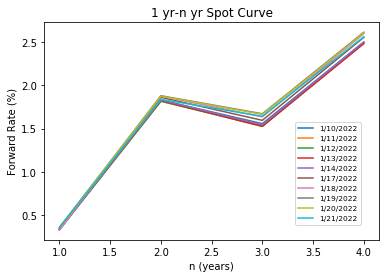

In [136]:
# Plot forward curve
for i in range(len(forwards)):
    plt.plot(years[i], forwards[i], label=dates[i])
plt.title("1 yr-n yr Spot Curve")
plt.xlabel("n (years)")
plt.ylabel("Forward Rate (%)")
plt.legend(loc = (0.75, 0.07), prop={'size': 7.5})
plt.savefig('forward.png')

In [178]:
# Calculate yield covariance and get eigenvalues/eigenvectors
def calculate_covariance(r1, r2):
    ans = np.dot(r1, r2) / len(r1)
    return ans

# interpolate to find n year yields
year_yield_rates = []
for i in range(len(dates)):
    yield_today = []
    y = yields[i]
    t = times[i]
    for j in range(1, 6):
        t1 = t[2*j-1]
        t2 = t[2*j]
        y1 = y[2*j-1]
        y2 = y[2*j]
        ratio = (j-t1) / (t2-t1)
        yiel = ratio * y1 + (1 - ratio) * y2
        yield_today.append(yiel)
    year_yield_rates.append(yield_today)

yield_returns = []
for i in range(5): # calculate log returns
    y = []
    for j in range(len(dates)-1):
        x = log(year_yield_rates[j+1][i] / year_yield_rates[j][i])
        y.append(x)
    yield_returns.append(y)

cov1 = []
for i in range(5): # calculate covariance matrix
    row = []
    for j in range(5):
        x = calculate_covariance(yield_returns[i], yield_returns[j])
        row.append(x)
    cov1.append(row)

print("Covariance Matrix for Yield")
for row in cov1:
    print(row)
    
# eigenvectors from np.linalg.eig are the columns (not the rows)
w, v = np.linalg.eig(cov1)
print()
print("Eigenvalues and Eigenvectors")
for i in range(5):
    print(w[i], 10*v[:,i])

Covariance Matrix for Yield
[0.000843344752318721, 0.0006303775230270182, 0.00039096990454762253, 0.0004578551840890369, 0.00034882247675808157]
[0.0006303775230270182, 0.0005016007213747434, 0.0003049242603841208, 0.0003796522900839319, 0.000276199533288612]
[0.00039096990454762253, 0.0003049242603841208, 0.0002017030545496684, 0.0002366576605689302, 0.00018107461116952824]
[0.0004578551840890369, 0.0003796522900839319, 0.0002366576605689302, 0.00034036749647628484, 0.00023594734039446446]
[0.00034882247675808157, 0.000276199533288612, 0.00018107461116952824, 0.00023594734039446446, 0.00017593618493163515]

Eigenvalues and Eigenvectors
0.0019551394980230176 [-6.45064458 -5.01722634 -3.1328299  -3.88830985 -2.87802843]
7.853177492154025e-05 [ 5.89189113  0.29194035 -0.43449081 -7.35385568 -3.30642012]
1.6327958956615034e-06 [-1.1279269   3.09648561 -4.63967008 -3.78803629  7.29820529]
1.09910987247489e-05 [-4.63825402  5.37045706  6.0754252  -3.4472167  -0.92233195]
1.665704208608498e-

In [176]:
# Calculate forward covariance and get eigenvalues/eigenvectors
forward_x = []
for i in range(4): # calculate log returns
    f = []
    for j in range(len(dates)-1):
        x = log(forwards[j+1][i] / forwards[j][i])
        f.append(x)
    forward_x.append(f)

cov2 = []
for i in range(4): # calculate covariance matrix
    row = []
    for j in range(4):
        x = calculate_covariance(forward_x[i], forward_x[j])
        row.append(x)
    cov2.append(row)

print("Covariance Matrix for Forward Rates")
for row in cov2:
    print(row)
w, v = np.linalg.eig(cov2)
print()
print("Eigenvalues and Eigenvectors")
for i in range(4):
    print(w[i], 10*v[:,i])

Covariance Matrix for Forward Rates
[0.0008853560848086824, 2.1833721573240072e-05, 0.0001467275434345988, 6.925230636297328e-06]
[2.1833721573240072e-05, 9.383768754053446e-05, 0.0001309677702465267, 0.00010082848637811577]
[0.0001467275434345988, 0.0001309677702465267, 0.0002958216014810146, 0.00018114298397446405]
[6.925230636297328e-06, 0.00010082848637811577, 0.00018114298397446405, 0.00013126395851102205]

Eigenvalues and Eigenvectors
0.0009274884573485239 [9.59391532 0.75406578 2.60622553 0.77185625]
0.0004480502830337918 [ 2.65183535 -3.9418698  -7.06966512 -5.23920479]
2.7938018956284858e-05 [-0.7249059  -8.12495016  5.52581589 -1.71027926]
2.802573002651971e-06 [ 0.63171947 -4.22826586 -3.56269313  8.3084244 ]
